In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys 
import networkx as nx 
import seaborn as sns 
from constants import ROOT_DIR

# setting the path of this notebook to the root directory
sys.path.append(ROOT_DIR)
# import libraries custom in this repository
import methods.DataIO as DataIO
import methods.GromovWassersteinFramework as GWL
import dev.generate_util as Gen

sns.set()
%matplotlib inline

Set experiment parameters: 

- `GEN_FUNC` is the generating function for a graph adjacency matrix
- `UNDIRECTED` is a boolean for whether the graph is undirected
- `BASE_SIZE` is the number of nodes in the smaller graph
- `MAX_DIFF` is the maximum discrepancy between the base graph and a larger graph
- `INCREMENTS` is the incremental unit between base graph and larger graph from iteration (i) to (i + 1)
- `OT_DICT` is a dictionary containing the arguments to the optimal transport training process

In [2]:
BASE_SIZES = [10, 25, 50]
NUM_EXP = 50
COLORS = ["blue", "orange", "green", "red", "purple"]
OUTER_ITER = 1000
INNER_ITER = 10

OT_DICT = {'loss_type': 'L2',  # the key hyperparameters of GW distance
            'ot_method': 'entropy',
            'beta': 1e-2,
            'outer_iteration': OUTER_ITER,  # outer, inner iteration, error bound of optimal transport
            'iter_bound': 1e-30,
            'inner_iteration': INNER_ITER,
            'sk_bound': 1e-30,
            'max_iter': 1,  # iteration and error bound for calcuating barycenter
            'cost_bound': 1e-16,
            'update_p': False,  # optional updates of source distribution
            'lr': 0.1,
            'node_prior': None,
            'alpha': 0,
            'test_mode': True}

In [3]:
def gwf_diff_experiment(gen_func, gen_func_name, base_sizes, n_experiments, colors, verbose = False, undirected = True, increments = 1): 

    plt.figure(figsize=(5, 5))
    plt.xlabel('Difference in Size')
    plt.ylabel('GW discrepancy')
    plt.title(gen_func_name)

    for num_base in range(len(base_sizes)): 
        # initialize storage vector for experimental results
        results_mean = np.zeros(n_experiments)
        results_std = np.zeros(n_experiments)

        # initialize base graph 
        base_size = base_sizes[num_base]
        if verbose: 
            print(f"Operating with base size = {base_size} --------------------------------")
        base_graph = nx.Graph(gen_func(base_size))
        p_s, cost_s, _ = DataIO.extract_graph_info(base_graph)
        p_s /= np.sum(p_s) 
        if undirected: 
            cost_s = cost_s + cost_s.T

        for i in range(n_experiments): 
            # create a new instance of graph with INCREMENT larger size 
            # than the previous iteration
            new_size = base_size + i * increments
            new_graph = nx.Graph(gen_func(new_size))
            p_t, cost_t, _ = DataIO.extract_graph_info(new_graph)
            p_t /= np.sum(p_t)
            if undirected: 
                cost_t = cost_t + cost_t.T
            # compute gromov-wasserstein differential between base graph and new graph
            d_gw = None
            for j in range(INNER_ITER): 
                trans, d_gw, _ = GWL.gromov_wasserstein_discrepancy(cost_s, cost_t, p_s, p_t, OT_DICT)
            # store the mean and SDs 
            results_mean[i] = np.mean(d_gw)
            results_std[i] = 0.25 * np.std(d_gw)

            # print progression bars 
            if verbose: 
                if np.round(n_experiments * 0.25) == i: 
                    print("25%===>")
                elif np.round(n_experiments * 0.50) == i: 
                    print("50%=========>")
                elif np.round(n_experiments * 0.75) == i: 
                    print("75%=================>")

        # visualize the results for current base size
        plt.plot(range(n_experiments), results_mean, label=f"Base size = {base_size}", color=colors[num_base])
        plt.fill_between(range(n_experiments), results_mean - results_std, results_mean + results_std,
                            color=colors[num_base], alpha=0.2)

    plt.legend()


Operating with base size = 10 --------------------------------
25%===>
50%=========>
75%=================>
Operating with base size = 25 --------------------------------
25%===>
50%=========>
75%=================>
Operating with base size = 50 --------------------------------
25%===>
50%=========>
75%=================>


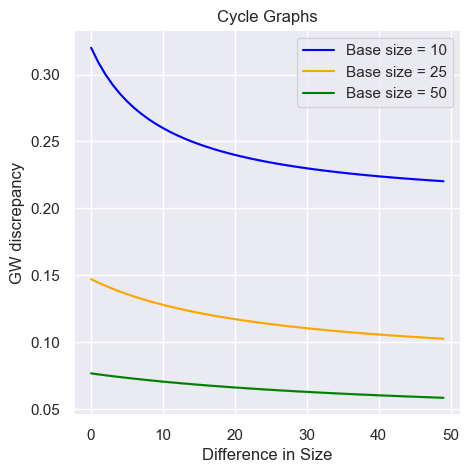

In [4]:
gwf_diff_experiment(Gen.gen_cycle_graph, "Cycle Graphs", BASE_SIZES, NUM_EXP, COLORS, verbose=True)

Operating with base size = 10 --------------------------------
25%===>
50%=========>
75%=================>
Operating with base size = 25 --------------------------------
25%===>
50%=========>
75%=================>
Operating with base size = 50 --------------------------------
25%===>
50%=========>
75%=================>


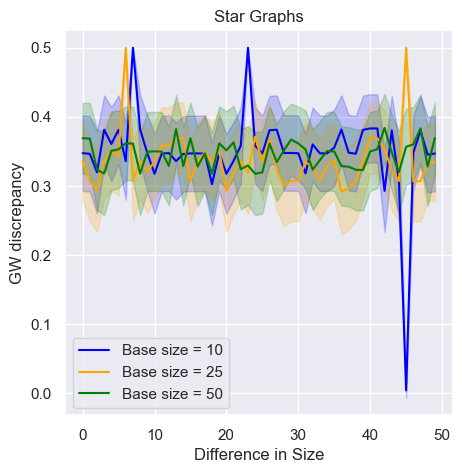

In [5]:
gwf_diff_experiment(Gen.gen_star_graph, "Star Graphs", BASE_SIZES, NUM_EXP, COLORS, verbose=True)